# The Relationship Between Crime Rates and External Factors In Chicago
 


### Introduction
In the constant effort to keep our living spaces safer, we are always looking for ways to mitigate crime rates. In order to develop effective ways to do so, we need to look at some of the root causes of crime itself; the factors that influence crime rates. This will allow us to develop preventative measures and take legal action to stop these crimes before they happen.

This project will take us through the data science life cycle, and allow us to see how data science and statistics can let us develop meaningful conclusions that have the potential to improve or even save the lives of millions of people


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree


### Datasets and Data Cleaning

In the early stages of the data science life cycle, we need to get our datatsets and filter them for the data we want.
In this case I have opted to use data from Kaggle:
(links)

For this project, we are focusing on the city of Chicago to do our data analysis. 
The external factors we are going to be considering for this project are:
* Temperature
* Consumer Price Index (general metric for cost of living)
* Electricity Prices

In the real world, we could consider dozens or even hundreds of different factors. However, these 3 factors will let us perform sufficient analysis for our project.

We are going to filter out the data we don't want, and save it as a new CSV for easy access. 

**Only run the cell below[3] ONE time!!**


In [2]:


#Data Cleaning

#only get national CPI from 1995 onwards
#I dont need CPI from like 1904
df = pd.read_csv('US CPI.csv')
df['Yearmon'] = pd.to_datetime(df['Yearmon'], format='%d-%m-%Y')
df = df[df['Yearmon'] >= '1995-01-01']
df.to_csv('US CPI filtered.csv', index = False)

#filter for chicago
df = pd.read_csv('city_temperature.csv')
df = df[df['City'] == 'Chicago']
df.to_csv('city_temp_chicago.csv', index=False)

#Clean electricity prices to filter for the state 
#of Illinois
df = pd.read_csv('US_Electricity_Prices.csv')
df = df[df['stateDescription'] == 'Illinois']
df.to_csv('US_Electricity_Illinois.csv', index = False)



C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\2352892721.py:11: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('city_temperature.csv')


Run this next cell to import the data we are going to use for the rest of this project.

Might take 30-40 seconds since one of our datasets is very large

In [3]:
#immport our filtered datasets
cpi = pd.read_csv('US CPI filtered.csv')
temperature = pd.read_csv('city_temp_chicago.csv')
electricity = pd.read_csv('US_Electricity_Illinois.csv')

#chicago crime data cleaning. 
#this file is massive so i dont want to make a copy of it 
df = pd.read_csv('Chicage Crime Data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

#this is a function we use later
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\2496311217.py:8: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Chicage Crime Data.csv')


Lets have a look at our data:

In [4]:
cpi.head()

,Yearmon,CPI
0,1995-01-01,150.3
1,1995-02-01,150.9
2,1995-03-01,151.4
3,1995-04-01,151.9
4,1995-05-01,152.2


'CPI' is the Consumer Price Index for the year and month given by 'Yearmon'.
However, this metric is for the US as a whole, not Chicago specifically.
For more info on CPI: https://www.investopedia.com/terms/c/consumerpriceindex.asp 

In [5]:
temperature.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,North America,US,Illinois,Chicago,1,1,1995,23.7
1,North America,US,Illinois,Chicago,1,2,1995,13.8
2,North America,US,Illinois,Chicago,1,3,1995,14.1
3,North America,US,Illinois,Chicago,1,4,1995,3.8
4,North America,US,Illinois,Chicago,1,5,1995,5.0


Our 'temperature' dataset gives us the average temperature for every day since January 1, 1995, until 2020, in the city of Chicago

In [6]:
electricity.head()

,year,month,stateDescription,sectorName,customers,price,revenue,sales
0,2001,1,Illinois,all sectors,NaN,5.87,727.44186,12382.56439
1,2001,1,Illinois,commercial,NaN,5.81,214.59817,3692.91148
2,2001,1,Illinois,industrial,NaN,4.03,140.61220,3489.34187
3,2001,1,Illinois,other,NaN,5.44,50.24250,924.09617
4,2001,1,Illinois,residential,NaN,7.53,321.98899,4276.21487


Our 'electricity' dataset gives us the the prices, revenue, and sales of the different sectors in the state of Illinois.
* Price is in cents per Kilowatt-hour (kWh)
* Revenue is in millions of dollars
* Sales is in millions of Kilowatt-hours (kWh)

In [7]:
df.head()


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Month
0,5741943,HN549294,2007-08-25 09:22:18,074XX N ROGERS AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,1.0,08A,NaN,NaN,2007.0,08/17/2015 03:03:40 PM,NaN,NaN,NaN,8.0
1,25953,JE240540,2021-05-24 15:06:00,020XX N LARAMIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,...,19.0,01A,1141387.0,1913179.0,2021.0,11/18/2023 03:39:49 PM,41.917838,-87.755969,"(41.917838056, -87.755968972)",5.0
2,26038,JE279849,2021-06-26 09:24:00,062XX N MC CORMICK RD,0110,HOMICIDE,FIRST DEGREE MURDER,PARKING LOT,True,False,...,13.0,01A,1152781.0,1941458.0,2021.0,11/18/2023 03:39:49 PM,41.995219,-87.713355,"(41.995219444, -87.713354912)",6.0
3,13279676,JG507211,2023-11-09 07:30:00,019XX W BYRON ST,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,5.0,05,1162518.0,1925906.0,2023.0,11/18/2023 03:39:49 PM,41.952345,-87.677975,"(41.952345086, -87.677975059)",11.0
4,13274752,JG501049,2023-11-12 07:59:00,086XX S COTTAGE GROVE AVE,0454,BATTERY,"AGGRAVATED P.O. - HANDS, FISTS, FEET, NO / MIN...",SMALL RETAIL STORE,True,False,...,44.0,08B,1183071.0,1847869.0,2023.0,12/09/2023 03:41:24 PM,41.737751,-87.604856,"(41.737750767, -87.604855911)",11.0


Our 'df' dataframe is the main focus of this project. It contains 7,391,187 criminal cases as well as a bunch of information associated with each case. 

We will mostly focus on the following columns:
* Primary Type: the category of the crime
* Arrest: whether or not an arrest was made
* Domestic: whether or not the case was a domestic crime or not
* Date: the day the crime occurred 



## Data Visualization
Now that we have cleaned our datasets, lets see what our datasets really look like.


### Part 1


To start, lets look at the relationships between our finance-related datasets. 
We expect the general trend for CPI and electricity prices to be increasing due to inflation.

We are going to plot electricty prices, revenue, and CPI over time.
To do this, we have to do a little bit of pre-processing to make sure our plot comes out how we want

In [8]:

#initialize a date range for the plot
full_date_range = pd.date_range(start='2001-01-01', end=pd.to_datetime('today'), freq='M')

#make sure our dates are in datetime format
cpi['YearMonth'] = pd.to_datetime(cpi['Yearmon'], errors='coerce').dt.to_period('M')

electricity['YearMonth'] = pd.to_datetime(electricity[['year', 'month']].assign(day=1))
electricity['YearMonth'] = electricity['YearMonth'].dt.to_period('M')

#make sure our datasets are ordered in ascending order by date
#we need to groupby yearmonth because of the formatting differences of some of our datasets

avg_cpi = cpi.groupby('YearMonth')['CPI'].mean()
avg_cpi = avg_cpi.reindex(full_date_range.to_period('M'))
 
avg_electricity_price = electricity.groupby('YearMonth')['price'].mean()
avg_electricity_price = avg_electricity_price.reindex(full_date_range.to_period('M'))


avg_electricity_rev = electricity.groupby('YearMonth')['revenue'].mean()
avg_electricity_rev = avg_electricity_rev.reindex(full_date_range.to_period('M'))



C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\558707268.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  full_date_range = pd.date_range(start='2001-01-01', end=pd.to_datetime('today'), freq='M')


There are differences in the orders of magnitude of our datasets. If we aren't careful, our visualization will look like a child's depiction of a landscape. A green line at the bottom for the grass and a blue line at the top for the sky. 

To get around this, we are going to normalize everything so that we can see the overall trend over time more clearly.


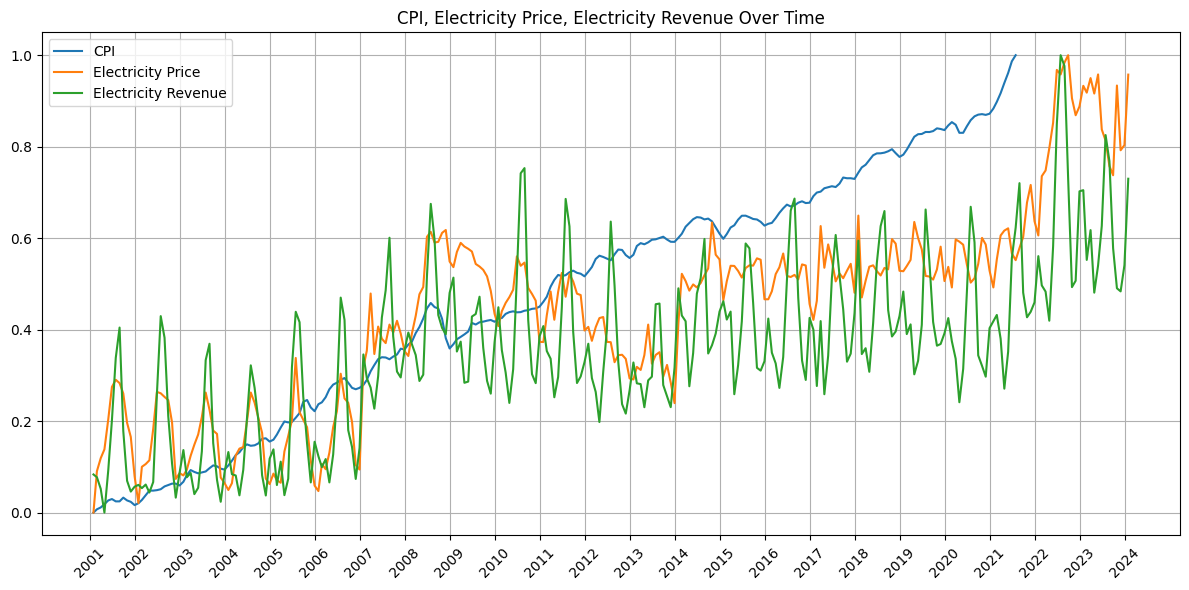

In [9]:

normalized_cpi = normalize(avg_cpi)
normalized_electricity_price = normalize(avg_electricity_price)
normalized_electricity_rev = normalize(avg_electricity_rev)


#time to plot
plt.figure(figsize=(12, 6))

plt.plot(full_date_range, normalized_cpi.values, label='CPI')
plt.plot(full_date_range, normalized_electricity_price.values, label='Electricity Price')
plt.plot(full_date_range, normalized_electricity_rev.values, label='Electricity Revenue')

# Customize the plot
plt.title('CPI, Electricity Price, Electricity Revenue Over Time')
plt.xticks(ticks=pd.date_range(start='2001-01-01', end=pd.to_datetime('today'), freq='YS'), 
           labels=pd.date_range(start='2001-01-01', end=pd.to_datetime('today'), freq='YS').strftime('%Y'), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


Cool! It looks like all the curves have a general increase like we expected. It makes sense to see electricity prices follow a similar trend as CPI because we expect electricity prices to be a factor when calculating cost of living. 

Look at the spikes that happen every year around summer time. This might tell us that air conditioning takes a lot more energy than heating, which drives energy prices up. We can't say for sure, but it's the first guess that comes to mind.



## Part 2

Since we have observed a sudden jump in electricity prices during the summer time, we can hypothesize that these higher prices could increase the likelihood of crimes being committed. So lets see if our guess has any merit.


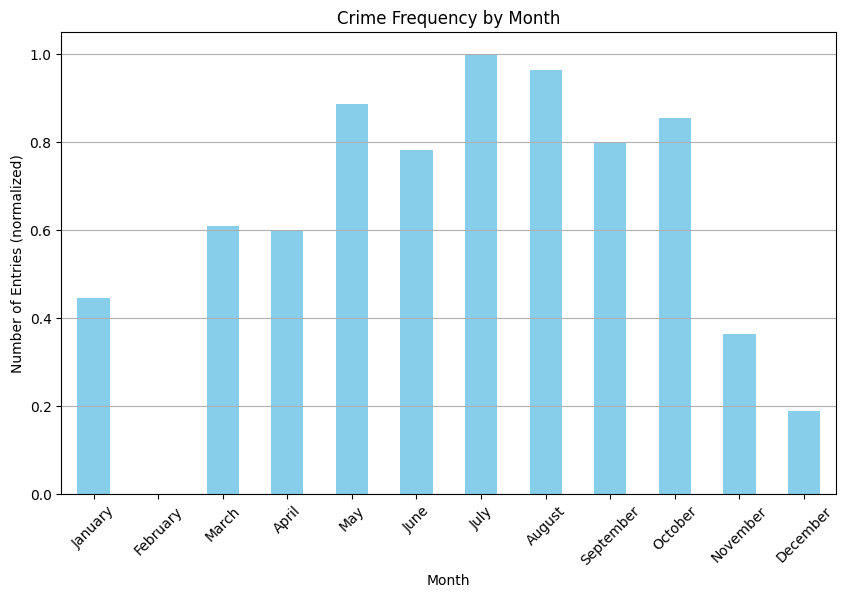

In [10]:


#first, we will plot the distribution of crimes in general. For our null hypothesis to be true,
#we should expect to see that all the crime categories like "ASSAULT", "ROBBERY", etc. 
# have a relatively similar distribution across months.

#there is a suprising correlation between month and crime frequency. 
#I think it has something to do with temperature and weather.
#hotter months like june and july tend to have higher crime frequencies.


plt.figure(figsize=(10, 6))

# Count the number of entries for each month and ensure all months are represented
monthly_counts = normalize(df['Month'].value_counts().reindex(range(1, 13), fill_value=0))

# Plot the counts
monthly_counts.plot(kind='bar', color='skyblue')
plt.title('Crime Frequency by Month')
plt.xlabel('Month')
plt.xticks(ticks=range(12), 
           labels=['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December'], 
           rotation=45)

plt.ylabel('Number of Entries (normalized)')
plt.grid(axis='y')


Interesting! It looks like our hypothesis isn't completely wrong.

However, we are good data scientists, and know that correlation is not necessarily causation.

The spike in crime rates during the summer months could be explained by many other factors we havent considered. 
I read online somewhere that when temperatures rise, people become irritable and more violent, which causes crimes related to temperament to increase. Lets test this hypothesis.
 
We are going to compare the distribution of homicide frequencies with other crimes that are less related to temperament. I've chosen narcotics and motor vehicle theft. 

<Figure size 1000x600 with 0 Axes>

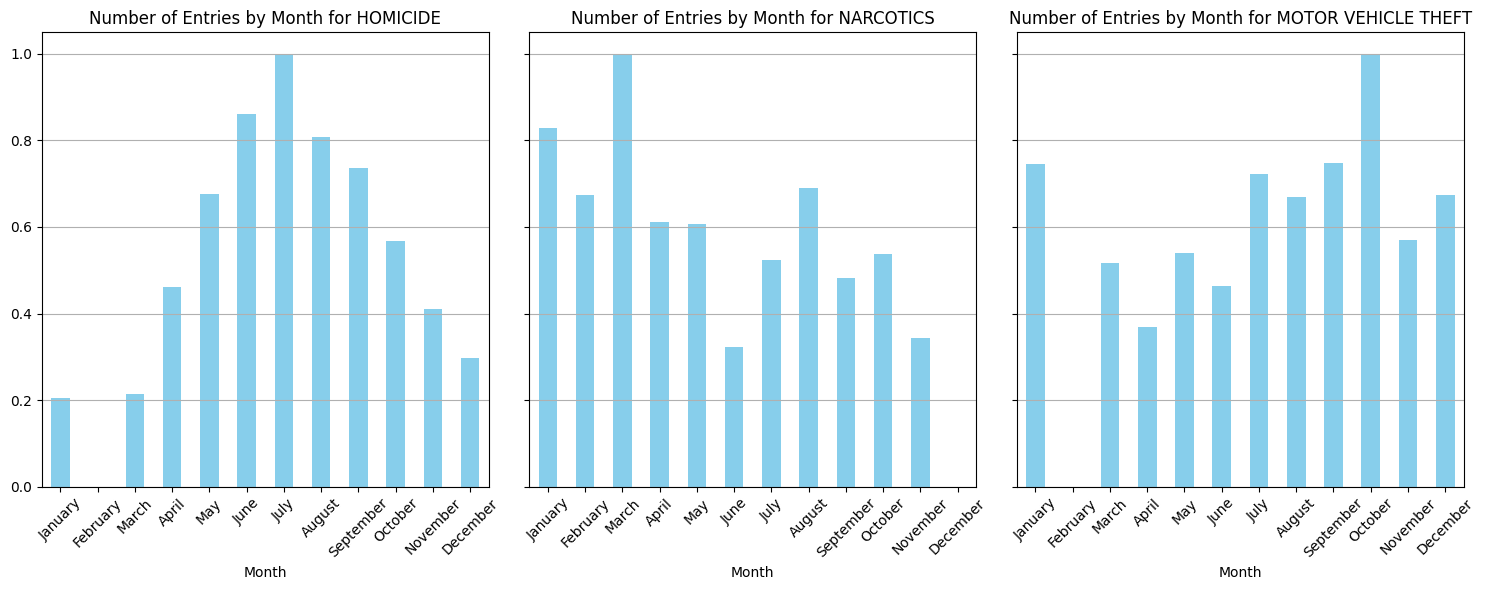

In [11]:
plt.figure(figsize=(10, 6))

#Lets plot out the distribution of these 3 categories
#I chose these three categories because I expect them to be
#the most different from each other. 

# I don't want to plot 'homicide' and 'assault' because they are similar crimes in nature.
#Additionally, I want to normalize each category because there are far more 
# narotics crimes than homicides, and I want to see the difference between
# months more clearly.

crime_types = ['HOMICIDE', 'NARCOTICS', 'MOTOR VEHICLE THEFT']  # Ive experimented with a few more, but these three look the best
num_crimes = len(crime_types)
fig, axes = plt.subplots(nrows=1, ncols=num_crimes, figsize=(15, 6), sharey=True)

for ax, crime in zip(axes, crime_types):
    normalized_counts = normalize(df[df['Primary Type'] == crime]['Month'].value_counts().reindex(range(1, 13), fill_value=0))
    normalized_counts.plot(kind='bar', color='skyblue', ax=ax)
    ax.set_title(f'Number of Entries by Month for {crime}')
    ax.set_xticks(range(12))
    ax.set_xticklabels(['January', 'February', 'March', 'April', 'May', 'June', 
                        'July', 'August', 'September', 'October', 'November', 'December'], 
                       rotation=45)
    ax.grid(axis='y')

plt.ylabel('Number of Entries')
plt.tight_layout()
plt.show()


#It seems like homicide has a very clear correlation with month, far more than Narcotics or Motor Vehicle Theft
#Conclusion:
# it seems like depending on the crime, the montly frequency of said crime can very from 
# category to category

Wow! Looks like there is a pretty clear difference in the distribution of crimes throughout the months! 

Notice how the y axis is between 0 and 1. We have normalized our data once again because of the difference in frequencies across different crime categories. There are going to be a lot less homicides than drug related crimes. What we care about is how the frequencies of these crimes change throughout different times of the year.

Now that we've had a good look at all our datasets, lets see how all of them might be related. 
Lets plot out our temperature, CPI, and electricity price curves over top our homicide frequency bar graph.



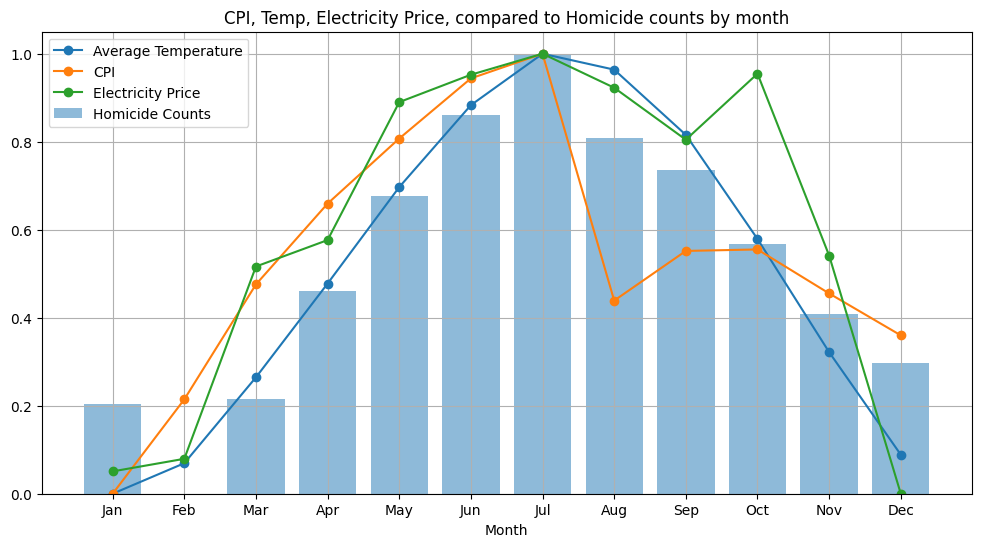

In [12]:

#Since cpi, and electricity price are recorded over many years, 
# I will just get the average of each month over all the years available.


# Convert 'Year', 'Month', and 'Day' to datetime for temperature data
temperature['Date'] = pd.to_datetime(temperature[['Year', 'Month', 'Day']])

# Group by month and calculate average temperature
temperature['Month'] = temperature['Date'].dt.month
avg_temperature = temperature.groupby('Month')['AvgTemperature'].mean()

# need to xtract month from CPI data
cpi['Yearmon'] = pd.to_datetime(cpi['Yearmon'])
cpi['Month'] = cpi['Yearmon'].dt.month

avg_cpi = cpi.groupby(cpi['Yearmon'].dt.month)['CPI'].mean()
avg_electricity_price = electricity.groupby(['year', 'month'])['price'].mean().reset_index()
avg_electricity_price = avg_electricity_price.groupby('month')['price'].mean()



#I am going to normalize the datasets again because the actual numeric values
#in each category are vastly different. 
#I only care about the changes between months here.

normalized_temperature = normalize(avg_temperature)
normalized_cpi = normalize(avg_cpi)
normalized_electricity_price = normalize(avg_electricity_price)

#Plot all the categories as curves
plt.figure(figsize=(12, 6))
plt.plot(normalized_temperature.index, normalized_temperature.values, label='Average Temperature', marker='o')
plt.plot(normalized_cpi.index, normalized_cpi.values, label='CPI', marker='o')
plt.plot(normalized_electricity_price.index, normalized_electricity_price.values, label='Electricity Price', marker='o')

# Plot HOMICIDE as a bar graph because its sort of the main character here
homicide_counts = normalize(df[df['Primary Type'] == 'HOMICIDE']['Month'].value_counts().reindex(range(1, 13), fill_value=0))
plt.bar(homicide_counts.index, homicide_counts.values, label='Homicide Counts', alpha=0.5)

#add some nice labels 
plt.title('CPI, Temp, Electricity Price, compared to Homicide counts by month')
plt.xlabel('Month')
plt.xticks(normalized_temperature.index, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid()
plt.show()


Normalization is awesome!
It looks like on average, the maximum temperature, CPI, electricity price, and homicide rates all hit their maximums in July! 

Now that we have a good idea of the relationship between our datasets, we want to see which statistics are most related to which statistics. A correlation matrix will be perfect for this job.



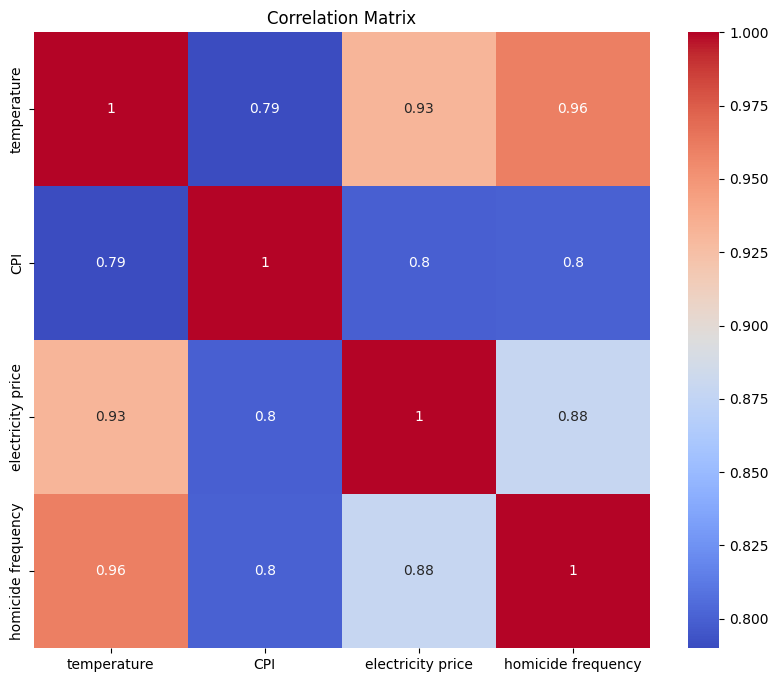

In [13]:
#Since we have seen a very nice correlation between our categories above, 
#lets make a correlation matrix 

#cool dataframe trick
data = {
    'temperature': normalized_temperature.values,
    'CPI': normalized_cpi.values,
    'electricity price': normalized_electricity_price.values,
    'homicide frequency': homicide_counts.values
}

correlation_df = pd.DataFrame(data)

# Calculate the correlation matrix
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

#Conclusion
#looks like homicide frequency has a near perfect correlation with temperature!
# The other things look very correlated too, but it might be the case that
# they are more closely related to temperature than to homicide rates.
# Its also completely possible that temperature and homicide rates are correlated
# for a different reason that I had not thought about.


How do we read this??

**How to Read a Correlation Matrix**:
Notice that the labels on the X and Y axis contain the same elements. The square (x,y) corresponds to the correlation between x and y. Notice that all values on the diagonal are 1. This is because every statistic has perfect correlation with itself, so these squares are trivial. Also notice that the matrix is symmetric about  the diagonal. This is because the correlation between x and y is equal to the correlation between y and x.

It looks like out of all of our factors, the most correlated pair is temperature to homicide frequency, which supports the hypothesis that high temperatures are related to higher violent crime rates. Another highly correlated pair is temperature and electricity price, which supports our hypothesis we made earlier about air conditioning and energy prices.

## Machine Learning

Visualizations are cool and all, but we are data scientists, and believe it or not, we don't want to read and interpret charts all day. We want the computer to do that for us. By using the data we have collected, we want to train the computer to make predictions about new data. The computer might even be able to recognize patterns we can't see.

### Part 1A: Regression

Before we start, we want our datasets to be easily 'digestible' by our machine learning models.

We are going to combine the features and labels that we want into one nice dataframe that can be easily split into testing and training sets.


In [14]:


#make a new column called 'date' 
#we will use this column to join our datasets together
temperature['date'] = pd.to_datetime(temperature[['Year', 'Month', 'Day']])

#crimes is the dataset we are going to join on
crimes = temperature[['date', 'AvgTemperature']].copy()

#rename so that this column is consistent across our many dataframes
crimes.rename(columns={'date': 'Date'}, inplace=True)

crimes.head()

,Date,AvgTemperature
0,1995-01-01,23.7
1,1995-01-02,13.8
2,1995-01-03,14.1
3,1995-01-04,3.8
4,1995-01-05,5.0


In [15]:
#crime_counts is a dataframe that gives us the number of each crime that has occured on each date
#We take all the crimes that have occured on the same day, 
# and count the number of each type of crime that occured on that day
#then, we make each category into its own column
crime_counts = df.groupby(df['Date'].dt.date)['Primary Type'].value_counts().unstack(fill_value=0)

#since we have grouped by date, the our crime_counts dataframe is indexed by 'Date' 
#we will convert our date to pandas DateTime
crime_counts.index = pd.to_datetime(crime_counts.index)

crime_counts.head()

Primary Type,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,DECEPTIVE PRACTICE,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-01,0,70,296,66,0,38,233,3,29,93,...,167,5,0,5,0,41,65,1,412,32
2001-01-02,0,66,143,68,0,2,118,0,35,78,...,101,11,0,2,0,35,4,0,221,9
2001-01-03,1,79,165,57,0,7,136,0,35,49,...,96,16,0,7,0,51,5,1,226,7
2001-01-04,1,57,173,55,0,2,133,0,29,42,...,96,19,0,3,0,55,1,0,243,9
2001-01-05,3,68,178,55,0,6,142,0,29,53,...,90,16,0,5,0,55,2,0,265,6


In [16]:
# Merge the temperature data with the crime counts on the date
crimes = crimes.merge(crime_counts, left_on='Date', right_index=True, how='left')

#drop missing values because they cause indigestion for our ML models
crimes = crimes.dropna()

crimes.head()

,Date,AvgTemperature,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,...,OTHER OFFENSE,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION
2192,2001-01-01,15.2,0.0,70.0,296.0,66.0,0.0,38.0,233.0,3.0,...,167.0,5.0,0.0,5.0,0.0,41.0,65.0,1.0,412.0,32.0
2193,2001-01-02,11.8,0.0,66.0,143.0,68.0,0.0,2.0,118.0,0.0,...,101.0,11.0,0.0,2.0,0.0,35.0,4.0,0.0,221.0,9.0
2194,2001-01-03,15.5,1.0,79.0,165.0,57.0,0.0,7.0,136.0,0.0,...,96.0,16.0,0.0,7.0,0.0,51.0,5.0,1.0,226.0,7.0
2195,2001-01-04,24.6,1.0,57.0,173.0,55.0,0.0,2.0,133.0,0.0,...,96.0,19.0,0.0,3.0,0.0,55.0,1.0,0.0,243.0,9.0
2196,2001-01-05,32.1,3.0,68.0,178.0,55.0,0.0,6.0,142.0,0.0,...,90.0,16.0,0.0,5.0,0.0,55.0,2.0,0.0,265.0,6.0



Right now the 'crimes' dataframe contains the daily average temperature and the number of crimes committed on that day for all crime categories. 
Since our CPI and electricity price datasets are dated by month, we will make some adjustments to accomodate:
* Sum up the total number of committed crimes of all categories in the month
* Get the month's median temperature.  

We could have filled in the monthly CPI and electricity price for each day in the month, but this could keep our data very 'noisy' since there might be high variation between the number of crimes committed per day. Additionally, the large amount of rows could make model training take longer than we have patience for.

In [17]:


# Resample the data by month and calculate the median temperature for AvgTemperature
crime_months = crimes.resample('M', on='Date').agg({'AvgTemperature': 'median'})

# Sum the counts of all columns except the first (AvgTemperature) for the month
crime_months = crime_months.join(crimes.resample('M', on='Date').sum().iloc[:, 1:], how='left')

#Change the 'Date' column to 'YearMonth' to matc hthe names of the other columns
crime_months['YearMonth'] = crime_months.index.to_period('M').astype(str)


#for some reason it doesn't work if I don't convert the dates to strings first
cpi['YearMonth'] = cpi['YearMonth'].astype(str)
crime_months['YearMonth'] = crime_months['YearMonth'].astype(str)
electricity['YearMonth'] = electricity['YearMonth'].astype(str)

# Ensure the YearMonth column in all DataFrames are of the same type
cpi['YearMonth'] = pd.to_datetime(cpi['YearMonth'], format='%Y-%m')  # Convert to datetime
crime_months['YearMonth'] = pd.to_datetime(crime_months['YearMonth'], format='%Y-%m')  # Convert to datetime
electricity['YearMonth'] = pd.to_datetime(electricity['YearMonth'], format='%Y-%m')  # Convert to datetime





C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\3819388843.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  crime_months = crimes.resample('M', on='Date').agg({'AvgTemperature': 'median'})
C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\3819388843.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  crime_months = crime_months.join(crimes.resample('M', on='Date').sum().iloc[:, 1:], how='left')


In [18]:
cpi.head()

,Yearmon,CPI,YearMonth,Month
0,1995-01-01,150.3,1995-01-01,1
1,1995-02-01,150.9,1995-02-01,2
2,1995-03-01,151.4,1995-03-01,3
3,1995-04-01,151.9,1995-04-01,4
4,1995-05-01,152.2,1995-05-01,5


In [19]:
electricity.head()

,year,month,stateDescription,sectorName,customers,price,revenue,sales,YearMonth
0,2001,1,Illinois,all sectors,NaN,5.87,727.44186,12382.56439,2001-01-01
1,2001,1,Illinois,commercial,NaN,5.81,214.59817,3692.91148,2001-01-01
2,2001,1,Illinois,industrial,NaN,4.03,140.61220,3489.34187,2001-01-01
3,2001,1,Illinois,other,NaN,5.44,50.24250,924.09617,2001-01-01
4,2001,1,Illinois,residential,NaN,7.53,321.98899,4276.21487,2001-01-01


In [20]:
crime_months.head()

,AvgTemperature,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,...,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,YearMonth
Date,,,,,,,,,,,,,,,,,,,,,
2001-01-31,24.6,67.0,2123.0,6525.0,1934.0,0.0,162.0,3966.0,3.0,1191.0,...,563.0,0.0,161.0,2.0,1396.0,218.0,26.0,7865.0,337.0,2001-01-01
2001-02-28,28.6,57.0,2029.0,6041.0,1666.0,0.0,134.0,3664.0,1.0,1063.0,...,426.0,1.0,173.0,0.0,1159.0,149.0,13.0,6669.0,301.0,2001-02-01
2001-03-31,34.3,93.0,2824.0,7659.0,1832.0,0.0,149.0,4617.0,5.0,1141.0,...,550.0,0.0,267.0,2.0,1399.0,184.0,17.0,7765.0,344.0,2001-03-01
2001-04-30,51.6,89.0,2747.0,8326.0,1931.0,0.0,132.0,4922.0,2.0,1133.0,...,564.0,1.0,229.0,1.0,1341.0,169.0,29.0,7702.0,321.0,2001-04-01
2001-05-31,59.5,94.0,2903.0,8888.0,1997.0,0.0,155.0,4756.0,2.0,1067.0,...,503.0,1.0,239.0,1.0,1491.0,226.0,11.0,8419.0,390.0,2001-05-01


Now that all dataframes have a matching 'YearMonth' column, we can join them together by this column

**ONLY RUN THIS CELL ONCE**

In [21]:

crime_months = crime_months.merge(cpi[['YearMonth', 'CPI']], on='YearMonth', how='left')


electricity_filtered = electricity[electricity['sectorName'] == 'all sectors']
crime_months = crime_months.merge(electricity_filtered[['YearMonth', 'price']], on='YearMonth', how='left')  # Use merge instead of join for consistency
crime_months = crime_months.dropna()  # Remove any rows with missing values

#one potential drawback of this is that
#CPI and electricity prices constantly increase with inflation, which might make our
#predictions innacurate.
#since CPI and electricity prices are expected to continue to grow(because of inflation)
#any real-world use case of this prediction would have a high likelyhood
#of seeing CPI and electricity prices as a record high number, which 
#is sort of 'out of scope' of our training data.




In [22]:
#run this cell to see what our end result is
crime_months.head()


,AvgTemperature,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,CRIMINAL SEXUAL ASSAULT,CRIMINAL TRESPASS,...,PUBLIC PEACE VIOLATION,RITUALISM,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,YearMonth,CPI,price
0,24.6,67.0,2123.0,6525.0,1934.0,0.0,162.0,3966.0,3.0,1191.0,...,161.0,2.0,1396.0,218.0,26.0,7865.0,337.0,2001-01-01,175.1,5.87
1,28.6,57.0,2029.0,6041.0,1666.0,0.0,134.0,3664.0,1.0,1063.0,...,173.0,0.0,1159.0,149.0,13.0,6669.0,301.0,2001-02-01,175.8,6.17
2,34.3,93.0,2824.0,7659.0,1832.0,0.0,149.0,4617.0,5.0,1141.0,...,267.0,2.0,1399.0,184.0,17.0,7765.0,344.0,2001-03-01,176.2,6.47
3,51.6,89.0,2747.0,8326.0,1931.0,0.0,132.0,4922.0,2.0,1133.0,...,229.0,1.0,1341.0,169.0,29.0,7702.0,321.0,2001-04-01,176.9,6.61
4,59.5,94.0,2903.0,8888.0,1997.0,0.0,155.0,4756.0,2.0,1067.0,...,239.0,1.0,1491.0,226.0,11.0,8419.0,390.0,2001-05-01,177.7,6.88


Great! We have created a clean dataset full of potential features and labels. 

If we wanted to, we could use any of combination of the columns in this dataframe to predict the values in any other column.
For simplicity of this project, we will just focus on violent crime specifically. The crimes we will consider to be 'violent' are assault, battery, homicide, and domestic violence. And we will select Temperature, CPI, and electricity price as our features.

In [23]:
violent_crimes = crime_months[['AvgTemperature', 'YearMonth', 'CPI', 'price']].copy()
violent_crimes['VIOLENT_CRIMES'] = crime_months[['ASSAULT', 'BATTERY', 'HOMICIDE', 'DOMESTIC VIOLENCE']].sum(axis=1)
violent_crimes = violent_crimes.dropna()  # Optionally drop any rows with missing values

violent_crimes.head()

,AvgTemperature,YearMonth,CPI,price,VIOLENT_CRIMES
0,24.6,2001-01-01,175.1,5.87,8691.0
1,28.6,2001-02-01,175.8,6.17,8097.0
2,34.3,2001-03-01,176.2,6.47,10520.0
3,51.6,2001-04-01,176.9,6.61,11132.0
4,59.5,2001-05-01,177.7,6.88,11833.0


Now lets have some fun!

Lets look at the relationship between each the label and each feature individually. For this, we will use Linear Regression from sklearn.

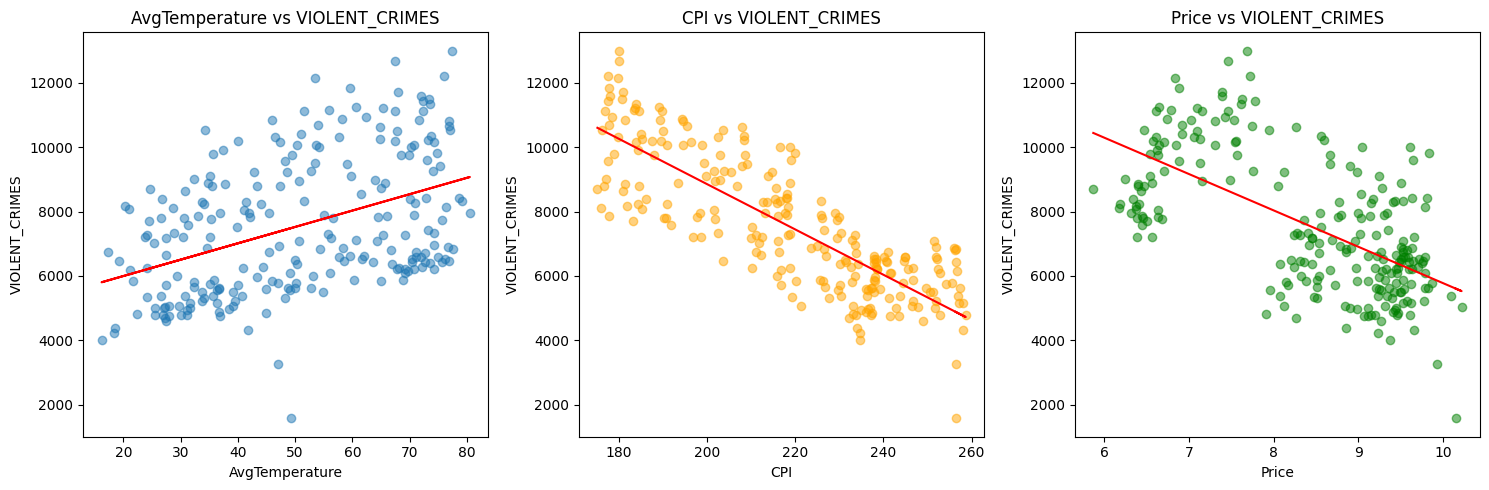

In [24]:



# Create scatterplots
plt.figure(figsize=(15, 5))




#------------------------------------------------
# Scatterplot for AvgTemperature vs VIOLENT_CRIMES
plt.subplot(1, 3, 1)
plt.scatter(violent_crimes['AvgTemperature'], violent_crimes['VIOLENT_CRIMES'], alpha=0.5)
# Fit line
model_temp = LinearRegression()
model_temp.fit(violent_crimes[['AvgTemperature']], violent_crimes['VIOLENT_CRIMES'])
plt.plot(violent_crimes['AvgTemperature'], model_temp.predict(violent_crimes[['AvgTemperature']]), color='red')
plt.title('AvgTemperature vs VIOLENT_CRIMES')
plt.xlabel('AvgTemperature')
plt.ylabel('VIOLENT_CRIMES')
#------------------------------------------------

#------------------------------------------------
# Scatterplot for CPI vs VIOLENT_CRIMES
plt.subplot(1, 3, 2)
plt.scatter(violent_crimes['CPI'], violent_crimes['VIOLENT_CRIMES'], alpha=0.5, color='orange')
# Fit line
model_cpi = LinearRegression()
model_cpi.fit(violent_crimes[['CPI']], violent_crimes['VIOLENT_CRIMES'])
plt.plot(violent_crimes['CPI'], model_cpi.predict(violent_crimes[['CPI']]), color='red')
plt.title('CPI vs VIOLENT_CRIMES')
plt.xlabel('CPI')
plt.ylabel('VIOLENT_CRIMES')
#------------------------------------------------

#------------------------------------------------
# Scatterplot for price vs VIOLENT_CRIMES
plt.subplot(1, 3, 3)
plt.scatter(violent_crimes['price'], violent_crimes['VIOLENT_CRIMES'], alpha=0.5, color='green')
# Fit line
model_price = LinearRegression()
model_price.fit(violent_crimes[['price']], violent_crimes['VIOLENT_CRIMES'])
plt.plot(violent_crimes['price'], model_price.predict(violent_crimes[['price']]), color='red')
plt.title('Price vs VIOLENT_CRIMES')
plt.xlabel('Price')
plt.ylabel('VIOLENT_CRIMES')
#------------------------------------------------


plt.tight_layout()
plt.show()




In [25]:
# Predictions
temp_predictions = model_temp.predict(violent_crimes[['AvgTemperature']])
cpi_predictions = model_cpi.predict(violent_crimes[['CPI']])
price_predictions = model_price.predict(violent_crimes[['price']])

# Calculate accuracy metrics
temp_mse = mean_squared_error(violent_crimes['VIOLENT_CRIMES'], temp_predictions)
temp_r2 = r2_score(violent_crimes['VIOLENT_CRIMES'], temp_predictions)

cpi_mse = mean_squared_error(violent_crimes['VIOLENT_CRIMES'], cpi_predictions)
cpi_r2 = r2_score(violent_crimes['VIOLENT_CRIMES'], cpi_predictions)

price_mse = mean_squared_error(violent_crimes['VIOLENT_CRIMES'], price_predictions)
price_r2 = r2_score(violent_crimes['VIOLENT_CRIMES'], price_predictions)

# Print accuracy metrics
print(f"AvgTemperature Model - MSE: {temp_mse:.2f}, R^2: {temp_r2:.2f}\n")
print(f"CPI Model - MSE: {cpi_mse:.2f}, R^2: {cpi_r2:.2f}\n")
print(f"Price Model - MSE: {price_mse:.2f}, R^2: {price_r2:.2f}\n")

AvgTemperature Model - MSE: 3601789.81, R^2: 0.19

CPI Model - MSE: 1460678.55, R^2: 0.67

Price Model - MSE: 2722418.33, R^2: 0.38



Interesting. It looks like CPI is the best predictor for the frequency of violent crime.

Lets see if considering all the features at once will make our predictions any more accurate. 
This looks like a job for KNN!

### Part 1B: K Nearest Neighbors


In [26]:


# Define features and label
X = violent_crimes[['AvgTemperature', 'CPI', 'price']]
y = violent_crimes['VIOLENT_CRIMES']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)

# # Print predicted values and actual values side by side
# for predicted, actual in zip(y_pred, y_test):
#     print(f"Predicted: {predicted}, Actual: {actual}")

# Calculate average error
average_error = abs(y_pred - y_test).mean()
print(f"Average Error: {average_error:.2f}")

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test,y_pred)
print(f"{mse=}")
print(f"{r2=}")



Average Error: 809.38
mse=1183105.0
r2=0.7479375511387085


Looks like considering all features using KNN gave us the most accurate predictions!


A drawback I forgot to mention before conducting these tests is that CPI and electricity prices have continually increased (due to inflation) and crime rates have continually decreased. This shift in crime rates over time is larger than the change in crime rates throughout the year, which inidicates to the ML model that the correlation between inflation and crime rates is stronger than the correlation between the seasonal changes in cost of living and crime rates.

This is why it is important to be aware of the potential existence of factors you have not considered to prevent us from making inaccurate conclusions.

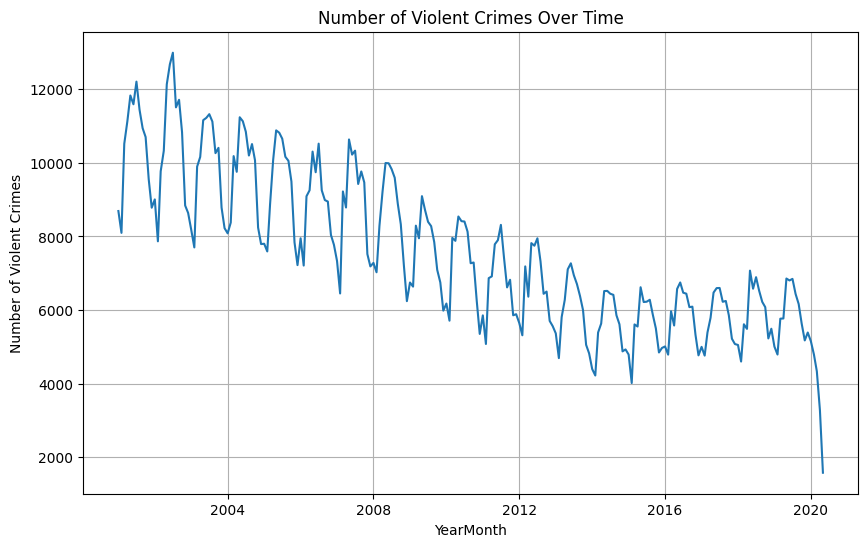

In [27]:
# Plot the number of violent crimes over time
plt.figure(figsize=(10, 6))
plt.plot(violent_crimes['YearMonth'], violent_crimes['VIOLENT_CRIMES'])
plt.title('Number of Violent Crimes Over Time')
plt.xlabel('YearMonth')
plt.ylabel('Number of Violent Crimes')
plt.grid(True)
plt.show()

### Part 2: Decision Trees, Random Forest, Logistic Regression

Now, lets take a look at classification. 
Instead of predicting numerical values, we will predict what category to put things in.

For our project, we will predict whether or not an arrest was made given the type of crime, the month, and whether or not it was a domestic crime. We will start by filtering out a few columns.

In [28]:

df_filtered = df[['Date', 'Primary Type', 'Location Description', 'Arrest', 'Domestic', 'Month']]
df_filtered['Arrest'] = df_filtered['Arrest'].fillna(False)
df_filtered['Domestic'] = df_filtered['Domestic'].fillna(False)
df_filtered['Arrest'] = df_filtered['Arrest'].astype(int)
df_filtered['Domestic'] = df_filtered['Domestic'].astype(int)

df_filtered.head()



C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\169052729.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_filtered['Arrest'] = df_filtered['Arrest'].fillna(False)
C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\169052729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Arrest'] = df_filtered['Arrest'].fillna(False)
C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\169052729.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. C

,Date,Primary Type,Location Description,Arrest,Domestic,Month
0,2007-08-25 09:22:18,ASSAULT,OTHER,0,0,8.0
1,2021-05-24 15:06:00,HOMICIDE,STREET,1,0,5.0
2,2021-06-26 09:24:00,HOMICIDE,PARKING LOT,1,0,6.0
3,2023-11-09 07:30:00,BURGLARY,APARTMENT,0,0,11.0
4,2023-11-12 07:59:00,BATTERY,SMALL RETAIL STORE,1,0,11.0


Look at Primary Type and Location Description. These are non-numerical values. We want to make sure there aren't **too** many categories, because it could really slow down the training speed of our models. Lets see how many categories we have to deal with:


In [29]:
pd.set_option('display.max_rows', None)
print(df_filtered['Location Description'].value_counts())
pd.reset_option('display.max_rows')

Location Description
STREET                                                   1923555
RESIDENCE                                                1243468
APARTMENT                                                 799520
SIDEWALK                                                  707612
OTHER                                                     269998
PARKING LOT/GARAGE(NON.RESID.)                            202960
ALLEY                                                     164396
SCHOOL, PUBLIC, BUILDING                                  146365
SMALL RETAIL STORE                                        137372
RESIDENCE-GARAGE                                          135521
RESIDENCE PORCH/HALLWAY                                   124184
RESTAURANT                                                120703
VEHICLE NON-COMMERCIAL                                    118938
GROCERY FOOD STORE                                         94992
DEPARTMENT STORE                                           94696
GAS 

In [30]:
pd.set_option('display.max_rows', None)
print(df_filtered['Location Description'].value_counts())

pd.reset_option('display.max_rows')

Location Description
STREET                                                   1923555
RESIDENCE                                                1243468
APARTMENT                                                 799520
SIDEWALK                                                  707612
OTHER                                                     269998
PARKING LOT/GARAGE(NON.RESID.)                            202960
ALLEY                                                     164396
SCHOOL, PUBLIC, BUILDING                                  146365
SMALL RETAIL STORE                                        137372
RESIDENCE-GARAGE                                          135521
RESIDENCE PORCH/HALLWAY                                   124184
RESTAURANT                                                120703
VEHICLE NON-COMMERCIAL                                    118938
GROCERY FOOD STORE                                         94992
DEPARTMENT STORE                                           94696
GAS 

We have so many different categories!!!!

This sucks because we have to somewhat manually decide which categories we want and how to reorganize everything. It also looks like there are some categories that are basically the same but are worded differently, or have trivial specifications. We need to consolidate.


**ONLY RUN THIS ONCE**

In [31]:



# Consolidation map
# everything in the VALUE arrays will map to its corresponding KEY
consolidation_map = {
    'RESIDENCE': [
        'RESIDENCE', 'RESIDENTIAL YARD (FRONT/BACK)', 'RESIDENCE PORCH/HALLWAY', 
        'RESIDENCE-GARAGE', 'DRIVEWAY - RESIDENTIAL', 'RESIDENCE - PORCH / HALLWAY',
        'RESIDENCE - YARD (FRONT / BACK)', 'RESIDENCE - GARAGE', 'CHA APARTMENT'
    ],
    'STORE': [
        'SMALL RETAIL STORE', 'GROCERY FOOD STORE', 'DEPARTMENT STORE',
        'CONVENIENCE STORE', 'DRUG STORE', 'TAVERN/LIQUOR STORE', 'LIQUOR STORE',
        'APPLIANCE STORE', 'CURRENCY EXCHANGE', 'BARBERSHOP', 'CLEANING STORE'
    ],
    'VEHICLE': [
        'VEHICLE NON-COMMERCIAL', 'VEHICLE-COMMERCIAL', 'TAXICAB',
        'DELIVERY TRUCK', 'VEHICLE - OTHER RIDE SHARE SERVICE (E.G., UBER, LYFT)',
        'VEHICLE - DELIVERY TRUCK', 'VEHICLE - COMMERCIAL: ENTERTAINMENT / PARTY BUS',
        'VEHICLE - COMMERCIAL: TROLLEY BUS', 'AUTO', 
        'TRUCK', 'BOAT/WATERCRAFT'
    ],
    'SCHOOL (PUBLIC + PRIVATE, BUILDING/GROUNDS)': [
        'SCHOOL, PUBLIC, BUILDING', 'SCHOOL, PUBLIC, GROUNDS', 
        'SCHOOL, PRIVATE, BUILDING', 'SCHOOL, PRIVATE, GROUNDS',
        'PUBLIC HIGH SCHOOL', 'PUBLIC GRAMMAR SCHOOL', 'SCHOOL - PUBLIC BUILDING',
        'SCHOOL - PUBLIC GROUNDS', 'SCHOOL - PRIVATE BUILDING', 'SCHOOL - PRIVATE GROUNDS'
    ],
    'BAR/TAVERN/LIQUOR STORE': [
        'BAR OR TAVERN', 'TAVERN', 'TAVERN/LIQUOR STORE'
    ],
    'PARKING LOT/GARAGE (NON-RESIDENTIAL)': [
        'PARKING LOT/GARAGE(NON.RESID.)', 'PARKING LOT / GARAGE (NON RESIDENTIAL)',
        'CHA PARKING LOT/GROUNDS', 'CTA PARKING LOT / GARAGE / OTHER PROPERTY'
    ],
    'PUBLIC TRANSPORT': [
        'CTA PLATFORM', 'CTA TRAIN', 'CTA BUS', 'CTA BUS STOP',
        'CTA STATION', 
        'CTA "L" TRAIN', 'CTA "L" PLATFORM', 'CTA PROPERTY',
        'CTA SUBWAY STATION', 'CTA TRACKS - RIGHT OF WAY',
        'AIRPORT/AIRCRAFT', 'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA',
        'AIRPORT TERMINAL LOWER LEVEL - NON-SECURE AREA',
        'AIRPORT TERMINAL UPPER LEVEL - NON-SECURE AREA',
        'AIRPORT TERMINAL LOWER LEVEL - SECURE AREA',
        'AIRPORT BUILDING NON-TERMINAL - NON-SECURE AREA',
        'AIRPORT BUILDING NON-TERMINAL - SECURE AREA',
        'AIRPORT PARKING LOT', 'AIRPORT EXTERIOR - NON-SECURE AREA',
        'AIRPORT EXTERIOR - SECURE AREA', 'AIRPORT VENDING ESTABLISHMENT',
        'AIRPORT TRANSPORTATION SYSTEM (ATS)'
    ]
}

#flatten the map to so we know which things should map to which consolidation
flattened_map = {loc: key for key, locations in consolidation_map.items() for loc in locations}

#Apply the consolidation
df_filtered['Location Description'] = df_filtered['Location Description'].replace(flattened_map)



#we still have some outlier categories 
#These are the top 16 categories with the most entries so we will keep these and set everything else to OTHER
valid_categories = [
    'STREET', 'RESIDENCE', 'APARTMENT', 'SIDEWALK', 'STORE', 'OTHER',
    'PARKING LOT/GARAGE (NON-RESIDENTIAL)', 'SCHOOL (PUBLIC + PRIVATE, BUILDING/GROUNDS)',
    'ALLEY', 'VEHICLE', 'PUBLIC TRANSPORT', 'RESTAURANT', 'GAS STATION',
    'BAR/TAVERN/LIQUOR STORE', 'PARK PROPERTY', 'COMMERCIAL / BUSINESS OFFICE'
]

# Anything not in the valid_categories will be put into OTHER
df_filtered['Location Description'] = df_filtered['Location Description'].apply(
    lambda x: x if x in valid_categories else 'OTHER'
)


C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\1733506933.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Location Description'] = df_filtered['Location Description'].replace(flattened_map)
C:\Users\evan3\AppData\Local\Temp\ipykernel_41696\1733506933.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Location Description'] = df_filtered['Location Description'].apply(


In [32]:
#run this cell to see the number of categories we have now
df_filtered['Location Description'].value_counts()

Location Description
STREET                                         1923555
RESIDENCE                                      1649939
APARTMENT                                       799520
SIDEWALK                                        707612
OTHER                                           623214
STORE                                           408911
PARKING LOT/GARAGE (NON-RESIDENTIAL)            269028
SCHOOL (PUBLIC + PRIVATE, BUILDING/GROUNDS)     199349
ALLEY                                           164396
VEHICLE                                         135947
PUBLIC TRANSPORT                                134096
RESTAURANT                                      120703
GAS STATION                                      80936
BAR/TAVERN/LIQUOR STORE                          63130
PARK PROPERTY                                    55835
COMMERCIAL / BUSINESS OFFICE                     55016
Name: count, dtype: int64

In [33]:
df_filtered.head()

,Date,Primary Type,Location Description,Arrest,Domestic,Month
0,2007-08-25 09:22:18,ASSAULT,OTHER,0,0,8.0
1,2021-05-24 15:06:00,HOMICIDE,STREET,1,0,5.0
2,2021-06-26 09:24:00,HOMICIDE,OTHER,1,0,6.0
3,2023-11-09 07:30:00,BURGLARY,APARTMENT,0,0,11.0
4,2023-11-12 07:59:00,BATTERY,STORE,1,0,11.0


Nice, we needed to do this because too many categories could make our models take longer to train.

To make this more digestible for our models, we will turn each category into its own column and have a 0 or 1 indicating whether or not each row is part of that category. Now it is more clear why we needed to consolidate so much. Otherwise we would just have way too many features.


**RUN THIS CELL ONCE ONLY**

In [34]:
df_filtered = df_filtered.join(pd.get_dummies(df_filtered['Primary Type'], prefix='', prefix_sep='', dtype=int))
df_filtered = df_filtered.join(pd.get_dummies(df_filtered['Location Description'], prefix='', prefix_sep='', dtype=int))

df_filtered.drop('Primary Type', axis=1, inplace=True)
df_filtered.drop('Location Description', axis = 1, inplace=True)
df_filtered = df_filtered.dropna(subset=['Date'])  # Remove rows with missing dates


In [35]:
#run this cell to see our dataset after all pre processing
df_filtered.head()

,Date,Arrest,Domestic,Month,ARSON,ASSAULT,BATTERY,BURGLARY,CONCEALED CARRY LICENSE VIOLATION,CRIM SEXUAL ASSAULT,...,PARK PROPERTY,PARKING LOT/GARAGE (NON-RESIDENTIAL),PUBLIC TRANSPORT,RESIDENCE,RESTAURANT,"SCHOOL (PUBLIC + PRIVATE, BUILDING/GROUNDS)",SIDEWALK,STORE,STREET,VEHICLE
0,2007-08-25 09:22:18,0,0,8.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-05-24 15:06:00,1,0,5.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2021-06-26 09:24:00,1,0,6.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023-11-09 07:30:00,0,0,11.0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023-11-12 07:59:00,1,0,11.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Now that we have completed pre processing, lets see which ML algorithm will give us the best Arrest=yes/no predictions.
To do this, we will compare the precision, recall and f1 score between a few different ML algorithms. More on these terms later.


In [36]:

X = df_filtered.drop(columns=['Date', 'Arrest'])
y = df_filtered['Arrest']



seed = 42 # always use this seed number as your random_state in the whole notebook
test_size = 0.2

# Randomly sample a specific number of rows
max_samples = 100000  # Set the maximum number of samples you want
X_sampled = X.sample(n=max_samples, random_state=seed)  # Randomly sample max_samples rows
y_sampled = y.loc[X_sampled.index]  # Get the corresponding y values


# Now split the sampled dataset
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=test_size, random_state=seed, shuffle=True)
#scale so that months are between 0 and 1, not sure if this matters or not
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#output is already either 0 or 1, so no need to scale

models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'LogisticRegression': LogisticRegression()

}

for model_name, model in models.items():
    np.random.seed(seed)
    model.fit(X_train_scaled, y_train)



# Evaluate the performance of each model
for model_name, model in models.items():
    np.random.seed(seed)

    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name}: {accuracy:.2f}")
    print(classification_report(y_test, y_pred)) 


Accuracy of DecisionTree: 0.86
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     14546
           1       0.85      0.61      0.71      5454

    accuracy                           0.86     20000
   macro avg       0.86      0.79      0.81     20000
weighted avg       0.86      0.86      0.86     20000

Accuracy of RandomForest: 0.86
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     14546
           1       0.84      0.62      0.71      5454

    accuracy                           0.86     20000
   macro avg       0.86      0.79      0.81     20000
weighted avg       0.86      0.86      0.86     20000

Accuracy of LogisticRegression: 0.86
              precision    recall  f1-score   support

           0       0.86      0.97      0.91     14546
           1       0.89      0.56      0.69      5454

    accuracy                           0.86     20000
   macro avg       0.87      

It seems like all 3 have relatively similar performance. The precision of all the models is pretty high, but the recall is particularly low. Before we continue there are a few terms we need to know:
* **Class Imbalance**: We have a class imbalance because there are more Arrest = No entries than there are Arrest = Yes entries. 
* **Precision**: Out of the number of times I predicted X, how many times was the actual answer not X?
* **Recall**: Out of the number of times the actual answer was X, how many times did I correctly predict X?
* **F1 Score**: an indicator that accounts for both precision and recall

Since we have such a disproportionate amount of Arrest=No to Arrest=Yes, our recall can become very low. Since our model sees 'No' so much more often than 'Yes', it trains itself to just go with 'No' most of the time since that is more likely to be correct. 

In situations like these, we need to think about what is more important to us: do we care more about just getting the prediction right, or do we care more about predicting a certain outcome correctly?

To show the tradeoff relationship between precision and recall, we will choose to maximize **recall**. In the following cell, we will stick with using a Decision Tree, because it has more parameters to tune, and we will be able to see a cool looking image of our decision tree at the end.



We want to make the BEST decision tree we can, so we will try many combinations of hyperparameters. The explanation for the numbers I chose are out of scope for this project so here is more information on hyperparameter tuning: https://www.geeksforgeeks.org/how-to-tune-a-decision-tree-in-hyperparameter-tuning/

The bottom line is, different combinations of hyperparameters can yield vastly different decision trees. So we are using GridSearch from sklearn to try all combinations of reasonable hyperparameter values to optimize for recall.


In [37]:


#lets tweak the parameters to see which combination gives us the best accuracy
param_grid = {
    'max_depth': [None, 10, 15, 20],
    'min_samples_split': [100, 1000],
    'min_samples_leaf': [100, 1000],
    'class_weight': ['balanced', {0: 1, 1: 3.5},{0: 1, 1: 4.5}]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), param_grid, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Use the best estimator
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}") # Your accuracy table header here
print(classification_report(y_test, y_pred)) 




Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.94      0.55      0.69     14546
           1       0.43      0.91      0.58      5454

    accuracy                           0.65     20000
   macro avg       0.69      0.73      0.64     20000
weighted avg       0.80      0.65      0.66     20000



Here we see some rather disappointing results. By prioritizing recall, we have sacrificed precision and overall accuracy. The reason we see this 'tradeoff' tendency is because when we prioritized recall, we are essentially making our model say 'Yes' more often. And knowing that we have a class imbalance towards 'No', saying 'Yes' more often will generally decrease the chances we get the answer right. 

Most of the time, we want precision and recall to be as close togther and as high as possible. If both precision and recall are high, it is an indicator that our model has detected a meaningful pattern in the data.

Because of our limited training data and time, it could be the case that the features we selected don't have nearly enough correlation for our decision tree to pick up on.

In [38]:
#Heres what our decision tree looks like
plt.figure(figsize=(160,80))
plot_tree(best_model, filled=True, feature_names=X.columns, class_names=['No Arrest', 'Arrest'], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

### Conclusion

In this project we have learned some important principles for data scientists:
* The importance of data pre-processing and normalization
* Being aware of the impact of potential un-accounted factors 
* The impact that class imbalance has when training ML models
* Relationships between precision and recall
* The limitations of ML models, specifically, decision trees


In the real world, these conclusions can be used as insight to policy-making to keep people safer. For example, if we found that domestic violence, or crimes committed in office spaces are less likely to lead to arrests, we could raise awareness of these potential issues or take other preventative actions in those areas. 

Understanding data science and its life cycle will allow us to approach real world issues that at a glance, seem too complex to tackle. By leveraging the massive amount of data on the internet, or collecting your own, you could be just one decision tree away from creating a solution that has a real impact on humanity.
